## Lab 3: Convolutional and NN




We will be applying CNN on the Shipping Dataset, which can be found on GitHub or at Kaggle.com. This dataset contains 4000 images of ships and no ships and each is a 80x80x3 pixel color image. Images with ships start with 1, and images without with a 0.

We will also be discovering the following themes:
- Functional API from Keras
- Pretrained models

In [70]:
import matplotlib.image as mpimg
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix

In [71]:
# Set image directory .
image_path = 'C:/Users/henrik.knudsen/OneDrive - BI Norwegian Business School (BIEDU)/Desktop/BI-Skole/3 Semester/DL and XAI/Labs/Lab 3/shipsnet/shipsnet/'

# Generate file list.
images = os.listdir(image_path)

# Check for valid image files.
valid_images = [image for image in images if image.endswith(('.jpg', '.png', '.jpeg'))]


# Create list of ship images.
ships = [np.array(mpimg.imread(image_path+image)) for image in images if image[0] == '1']
noShips = [np.array(mpimg.imread(image_path+image)) for image in images if image[0] == '0']


ships_saved = [np.array(mpimg.imread(image_path+image)) for image in images if image[0] == '1']
noShips_saved = [np.array(mpimg.imread(image_path+image)) for image in images if image[0] == '0']

In [72]:
# Printing out the result for how many images with noShips and Ships
print(len(noShips))
print(len(ships))

3000
1000


(80, 80, 3)
[0.3647059  0.43529412 0.38431373]


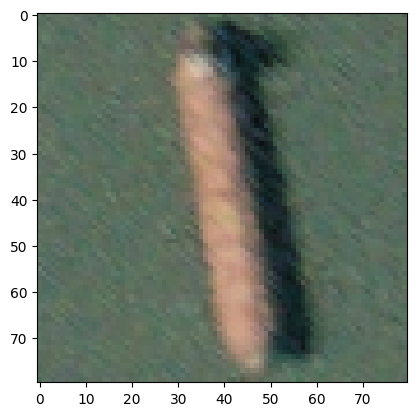

In [73]:
# Print item in list of ships
print(np.shape(ships[0]))

# Print pixel intensities in [0,0] position
print(ships[0][0,0])

# Show image of ship
plt.imshow(ships[0])

### Convolutional Network


Goal: Classify if image contains a ship or not
Structured data: If a pixel is a part of a ship, parts nearby are more likely to be ships too.

In the convolutional network, the images are the inputs, respectively their pixels as a tensor, one number for each color.

Ship dataset problem: 80x80x3 Pixel, need to reshape pixels so there are 19 200 input layer per image -> we need to flatten the data

In [74]:
# Reshape list of ship images
ships = [ship.reshape(19200,) for ship in ships]

# Reshape list of non-ship images
noShips = [noShip.reshape(19200,) for noShip in noShips]

# Define class labels
labels = np.vstack([np.ones((len(ships), 1)),
                    np.zeros((len(noShips), 1))])

# Stack flattened images into numpy array
features = np.vstack([ships, noShips])

print(len(ships[0]))
print(len(noShips[0]))

19200
19200


In [75]:
# Shuffle first and then split the data into train/test samples
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0, shuffle=True)

In [76]:
## Setting up the NN, we define inputlayer, 1 hidden layer and 1 output layer
# sequential NN
model = tf.keras.Sequential()

# Adding input layer
model.add(tf.keras.Input(shape=(19200,)))
# Hidden layer
model.add(tf.keras.layers.Dense(4, activation="sigmoid"))
# Output layer
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Model summary
print(model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 4)              │        76,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,809 (300.04 KB)

 Trainable params: 76,809 (300.04 KB)

 Non-trainable params: 0 (0.00 B)

None


Compile Model by specifiying a loss function and optimiser. We are using ADAM (Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments) and Accuracy metric

In [77]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(verbose=1)])

# Evaluate the model by accuracy
model.evaluate(X_test, y_test)

100%|██████████| 100/100 [00:23<00:00,  4.30epoch/s, accuracy=0.754, loss=0.558, val_accuracy=0.764, val_loss=0.547]

 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7188 - loss: 0.5974

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7420 - loss: 0.5713 


[0.5889720916748047, 0.7262499928474426]

In [78]:
## Confusion matrix to further check performance; elements on diagonal show correct predictions
# Generate predictions
y_pred = model.predict(X_test) > 0.5

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[581   0]
 [219   0]]


Based on the result from the confusion matrix, we see that all the predictions are 0's, which makes sense based on how unbalanced the samples are, i.e more no_shps than ships.
There are 2 solutions: balance out or apply weights in loss function to scale up ships

In [79]:
# Compute class weights
cw0 = np.mean(y_train)
cw1 = 1.0 - cw0
class_weights = {0:cw0, 1:cw1}
print(cw0)
print(class_weights)

0.2440625
{0: 0.2440625, 1: 0.7559375}


We need to re-fit the model, where we have scaled down no_ships by 25% because ships are 25% of the data. So now we have for both classes the same frequency

In [80]:
# Train the model with class_weights argument
model.fit(X_train, y_train, epochs=100, class_weight=class_weights, batch_size=32, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(verbose=1)])


100%|██████████| 100/100 [00:22<00:00,  4.36epoch/s, accuracy=0.246, loss=0.256, val_accuracy=0.236, val_loss=0.697]


In [81]:
# Generate predictions
y_pred = model.predict(X_test) > 0.5

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[  0 581]
 [  0 219]]


## Functional API in Keras

If we want to distinctly define inputs as inputs and outputs as outputs, we can do this in the functional API. We can also add information which helps to classify if a picture is (ship or no_ship) by the location. Functional API also allows for multiple output mdoels. 

Here, we differentiate between image inputs and meta inputs, and connect both layers:

In [82]:
# Define inputs
img_inputs = tf.keras.Input(shape=(19200,))
meta_inputs = tf.keras.Input(shape=(20,))

# Define dense layers
img_dense = tf.keras.layers.Dense(4,
          activation="sigmoid")(img_inputs)
meta_dense = tf.keras.layers.Dense(4,
          activation="sigmoid")(meta_inputs)

# Concatenate layers
merged = tf.keras.layers.Concatenate(axis=1)([
          img_dense, meta_dense])

# Define output layer
outputs = tf.keras.layers.Dense(1,
          activation="sigmoid")(merged)

# Define model using inputs and outputs
model_funct = tf.keras.Model(inputs=
          [img_inputs, meta_inputs],
          outputs=outputs)

# Model summary
print(model_funct.summary())

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 19200)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 4)         │     76,804 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 4)         │         84 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 8)         │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │          9 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,897 (300.38 KB)

 Trainable params: 76,897 (300.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
# Setting the parameters to run CNN
model = tf.keras.Sequential()

# Use Input layer to specify the input shape (in order to avoid error message from TF)
model.add(tf.keras.layers.Input(shape=(80, 80, 3)))

# Add first convolutional layer
model.add(tf.keras.layers.Conv2D(8, kernel_size = 3, activation="relu"))

# Add second layer
model.add(tf.keras.layers.Conv2D(8, kernel_size = 3, activation="relu"))

# Flatten feature maps
model.add(tf.keras.layers.Flatten())

# Define output layer
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 78, 78, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 76, 76, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │        46,209 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,017 (183.66 KB)

 Trainable params: 47,017 (183.66 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
## We notice that we have less parameters in the model, In the next step we need to prepare the data, and we do not need to reshape it

# Define class labels
labels = np.vstack([np.ones((len(ships_saved), 1)),
                    np.zeros((len(noShips_saved), 1))])

# Stack flattened images into numpy array
features = np.vstack([ships_saved, noShips_saved])

# Shuffle and split into train/test samples
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=0)

# Compute the class weights
cw0 = np.mean(y_train)
cw1 = 1.0 - cw0
class_weights = {0: cw0, 1:cw1}
print(class_weights)

{0: 0.2440625, 1: 0.7559375}


In [85]:
# Compile the model
model.compile(loss='binary_crossentropy',
optimizer='adam', metrics=['accuracy'])

# Train the model using class weights
model.fit(X_train, y_train, epochs = 10, 
	class_weight = class_weights,
	batch_size = 32, 
	validation_split = 0.20)

# Evaluate model
model.evaluate(X_test, y_test)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5986 - loss: 0.3666 - val_accuracy: 0.8219 - val_loss: 0.4407
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8477 - loss: 0.1403 - val_accuracy: 0.9141 - val_loss: 0.2562
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9063 - loss: 0.0931 - val_accuracy: 0.9312 - val_loss: 0.2042
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9403 - loss: 0.0669 - val_accuracy: 0.9250 - val_loss: 0.1879
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9478 - loss: 0.0527 - val_accuracy: 0.9234 - val_loss: 0.1865
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9505 - loss: 0.0512 - val_accuracy: 0.9156 - val_loss: 0.2223
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9645 - loss: 0.0395 - val_accuracy: 0.9391 - val_loss: 0.1368
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9627 - loss: 0.0365 - val_accuracy: 0.9422 - val_loss:

[0.15133443474769592, 0.9437500238418579]

We obtained a accuracy of over 94% with just 25 epochs!

## Pretrained models

We can use pretrained models if there is not sufficient data to train the model, and we can use these pretrained models for 2 tasks: Feature extraction and fine tuning

### Feature extraction

Below we download the ResNet50 from Keras, it is a 50 layer CNN and used for image classfication. It contains 4 parts:
1. CN Layers
2. Identity block
3. CN block
4. Fully connected layer

It uses residual connectiosn to learn deeper architectures of the network.
CN layers extract features from images such as edges, textures and shapes. Then followed by a max pooling layer to reduce spatial dimension. Next the identity block and CN blocks process and transforms features. Lastly, the Connected layer make final classification

In [86]:
# Load the pretrained model
model = tf.keras.applications.resnet50.ResNet50(weights = "imagenet", include_top=False)

# Print out the summary of the  model (more than 25 million parameters)
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_22[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [87]:
# We compile and fit the model, example with only 2 epochs
model.trainable = False

# Define input layer
inputs = tf.keras.Input(shape=(80, 80, 3))
x = model(inputs, training = False)

# Define pooling and output layers, and model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# Compile and train the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs = 2, 
	class_weight = class_weights,
	batch_size = 32, 
	validation_split = 0.20)

model.summary()

Epoch 1/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.7581 - loss: 2.9473 - val_accuracy: 0.7641 - val_loss: 3.8029
Epoch 2/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 370ms/step - accuracy: 0.7532 - loss: 3.0070 - val_accuracy: 0.7641 - val_loss: 3.8029


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

### Fine tuning

Purpose: Slight adjustments to convolutional filters to capture more relevant features, often this involves a different learning rate

In [88]:
# Set convolutional base to be untrainable
model.trainable = True

# Compile model with a low learning rate
model.compile(loss='binary_crossentropy', 
optimizer=tf.keras.optimizers.Adam(
learning_rate=1e-5), 
	metrics=['accuracy'])

# Perform fine-tuning.
model.fit(X_train, y_train, epochs = 1, 
	class_weight = class_weights)

model.summary()

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.7493 - loss: 3.0549


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)